In [1]:
import tensorflow as tf
import keras
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import random
%matplotlib inline

/Users/lifengwei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Q-Network

def create_model(hidden=[64, 64], action_size=4):
    model = keras.Sequential()
    model.add(keras.layers.Dense(hidden[0], activation='relu'))
    model.add(keras.layers.Dense(hidden[1], activation='relu'))
    model.add(keras.layers.Dense(action_size))
    return model

In [3]:
# Replay Buffer
class Replaybuffer:
    
    def __init__(self, Buffer_size, Batch_size):
        
        self.batchsize = Batch_size
        self.memory = deque(maxlen=Buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
    def add(self, state, action, reward, next_state, done):
        
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        
        experiences = random.sample(self.memory, self.batchsize)
        states = np.vstack([e.state for e in experiences if e is not None])
        actions = np.vstack([e.action for e in experiences if e is not None])
        rewards = np.vstack([e.reward for e in experiences if e is not None])
        next_states = np.vstack([e.next_state for e in experiences if e is not None])
        dones = np.vstack([e.done for e in experiences if e is not None])
        return states, actions, rewards, next_states, dones

In [4]:
# Agents
class Agent:
    
    def __init__(self, env, learning_rate, buffer_size, batch_size, alpha, gamma, tau, action_size, double, deterministic, number):
        
        self.alpha = alpha #parameter for sqn, entropy term
        self.gamma = gamma #future reward decay
        self.tau = tau #soft update
        self.lr = learning_rate #lr
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.env = env #call it in .train()
        
        self.state_size = env.observation_space.shape
        self.action_size = env.action_space.n
        self.number = number
        self.kind = 'dqn' if deterministic else 'sqn'
        self.local_name = 'agent_{}_{}_local_net'.format(number, self.kind)
        self.target_name = 'agent_{}_{}_target_net'.format(number, self.kind)
        
        self.replaybuffer = Replaybuffer(buffer_size, batch_size)
        
        self.q_local = create_model(action_size = self.action_size)
        self.q_local.name = self.local_name
        self.q_target = create_model(action_size = self.action_size)
        self.q_target.name = self.target_name
        
        self.double = double #whether use double q-network
        
        self.deterministic = deterministic #whether use deterministic network. i.e. dqn or sqn
        
        #define placeholders
        self.tf_states = tf.placeholder(dtype=tf.float32, shape=(None,)+self.state_size)
        self.tf_next_states = tf.placeholder(dtype=tf.float32, shape=(None,)+self.state_size)
        self.tf_actions = tf.placeholder(dtype=tf.int32, shape=[None, 1])
        self.tf_dones = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        self.tf_rewards = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        
        #define graph for action values, will be called in .act()
        self.action_values = self.q_local(self.tf_states)
        self.check_values = self.q_target(self.tf_states)
        
        #define graph for loss, will be called in .learn()
        if self.deterministic:
            #this is for dqn
            self.target_values_all = self.q_target(self.tf_next_states)
            self.target_values_max = tf.reduce_max(self.target_values_all, axis=1, keepdims=True)
            self.target_values = self.tf_rewards + self.gamma*(1-self.tf_dones)*self.target_values_max
            self.target_values = tf.stop_gradient(self.target_values)
        else:
            #this is for sqn
            self.target_values_all = self.q_target(self.tf_next_states)
            self.log_probs = tf.nn.log_softmax(self.target_values_all/self.alpha, axis=1)
            self.row_wise_max = tf.reduce_max(self.target_values_all, axis=1, keepdims=True)
            self.logits = self.log_probs + self.target_values_all/self.alpha - self.row_wise_max/self.alpha
            self.V = self.row_wise_max + self.alpha*tf.log(tf.reduce_sum(tf.exp(self.logits), axis=1, keepdims=True))
            self.target_values = self.tf_rewards + self.gamma*(1-self.tf_dones)*self.V
            self.target_values = tf.stop_gradient(self.target_values)
        
        self.indices = tf.stack([tf.range(self.batch_size), tf.reshape(self.tf_actions, [-1])], axis=1)
        self.expected_values = tf.gather_nd(self.action_values, self.indices)
        self.expected_values = tf.reshape(self.expected_values, [-1, 1])
        self.loss = tf.losses.mean_squared_error(self.expected_values, self.target_values)
        
        #get variable lists for weight updates
        self.local_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = self.local_name)
        self.target_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = self.target_name)
        #hard and soft weights updates
        with tf.variable_scope('hard_replacement'):
            self.hard_update = [tf.assign(self.target_variables[i], self.local_variables[i]) for i in range(len(self.target_variables))]
        with tf.variable_scope('hard_replacement'):
            self.soft_update = [tf.assign(self.target_variables[i], self.local_variables[i]*self.tau+self.target_variables[i]*(1-self.tau)) for i in range(len(self.target_variables))]
        
        #define optimizer, will be called in .learn()
        self.optim = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        
        #Initialize
        self.session = tf.Session()
        self.session.run(tf.initializers.global_variables())
        self.session.run(self.hard_update)
        
    def reset(self, new_lr=None, new_bs=None, new_alpha=None):
        #clear the memory of this agent, change some hyper parameters, reset network weights
        if new_lr is not None:
            self.lr = new_lr
        if new_bs is not None:
            self.batch_size = new_bs
        if new_alpha is not None:
            self.alpha = new_alpha
        self.session.run(tf.initializers.global_variables())
        self.replaybuffer = Replaybuffer(self.buffer_size, self.batch_size)
        
    def act(self, state, eps=0):
        
        values = self.session.run(self.action_values, feed_dict={self.tf_states:state})
        
        if self.deterministic:
            #the dqn route
            p = np.random.random()
            if p<eps:
                action = int(np.random.randint(self.action_size))
            else:
                action = np.argmax(values)
        else:
            #the sqn route
            values = values.reshape(-1)
            logits = (values - max(values))/self.alpha
            probs = np.exp(logits)/np.sum(np.exp(logits))
            action = int(np.random.choice(self.action_size, size=1, replace=False, p=probs))
        
        return action
    
    def learn(self, experience):
        
        states, actions, rewards, next_states, dones = experience
        
        loss, _ = self.session.run([self.loss, self.optim], feed_dict={self.tf_states:states,
                                                                       self.tf_actions:actions,
                                                                       self.tf_next_states:next_states,
                                                                       self.tf_rewards:rewards,
                                                                       self.tf_dones:dones})
        
        self.session.run(self.soft_update)
        
        return loss
        
        
    def add(self, state, action, reward, next_state, done):
        
        self.replaybuffer.add(state, action, reward, next_state, done)
        
    def train(self, n_iteration, max_t, learn_schedule):
        
        reward_recorder = []
        reward_window = deque(maxlen=100)
        mean_reward_recorder = []
        loss_recorder = []
        eps = 1
        
        for i in range(1, n_iteration+1):
            
            episodic_reward = 0
            t = 0
            state = self.env.reset()
            state = np.expand_dims(state, 0)
            
            while t<max_t:
                action = self.act(state=state, eps=eps)
                next_state, reward, done, _ = env.step(action)
                next_state = np.expand_dims(next_state, 0)
                episodic_reward += reward
                self.add(state, action, reward, next_state, done)
                state = next_state.copy()
                
                if (t % learn_schedule == 0) & (len(self.replaybuffer.memory)>self.batch_size):
                    experience = self.replaybuffer.sample()
                    loss = self.learn(experience)
                    loss_recorder.append(loss)
                
                if done:
                    break
                    
                t += 1
            
            reward_recorder.append(episodic_reward)
            reward_window.append(episodic_reward)
            mean_reward_recorder.append(np.mean(reward_window))
            
            print('\rEpisode {}\tEpisodic Score: {:.2f}\tAverage Score: {:.2f}'.format(i, episodic_reward, mean_reward_recorder[-1]), end='')
            if i % 100 == 0:
                print()
                
            eps *= 0.995
            if eps<0.01:
                eps = 0.01
                
        return reward_recorder, loss_recorder, mean_reward_recorder

In [5]:
# Initialize environment
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
State shape:  (8,)
Number of actions:  4


In [6]:
# Random agent

total_reward = 0

state = env.reset()
for j in range(200):
    action = int(np.random.randint(4, size=1))
    env.render()
    state, reward, done, _ = env.step(action)
    total_reward += reward
    if done:
        break 
        
env.close()

print('Total reward {}'.format(total_reward))

Total reward -273.6171645162862


In [7]:
import matplotlib.pyplot as plt

def plot_result(scores, means, suptitle):
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(suptitle)
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    average = np.mean(means, axis=0)
    error_bar = np.std(means, axis=0)/np.sqrt(15)
    upper = np.amax(means, axis=0)
    lower = np.amin(means, axis=0)
    ax1.plot(range(2000), average, label='Trajectory of moving average', color='yellow')
    ax1.plot(range(2000), upper, label='Upper bound', color='black')
    ax1.plot(range(2000), lower, label='Lower bound', color='black')
    ax1.fill_between(range(2000), average+1.96*error_bar, average-1.96*error_bar, alpha=0.5)
    ax1.plot(range(2000), 200*np.ones(2000), label='Benchmark',color='gray')
    ax1.set_ylabel('Average')
    ax1.set_xlabel('Episode #')
    ax1.legend(loc=4)
    ax1.set_ylim([-500, 300])
    ax1.set_title('Trajectory for moving average')
    
    average = np.mean(scores, axis=0)
    error_bar = np.std(scores, axis=0)/np.sqrt(15)
    upper = np.amax(scores, axis=0)
    lower = np.amin(scores, axis=0)
    ax2.plot(range(2000), average, label='Trajectory of episodic scores', color='yellow')
    ax2.fill_between(range(2000), average+1.96*error_bar, average-1.96*error_bar, alpha=0.5)
    ax2.plot(range(2000), upper, label='Upper bound', color='black')
    ax2.plot(range(2000), lower, label='Lower bound', color='black')
    ax2.plot(range(2000), 200*np.ones(2000), label='Benchmark',color='gray')
    ax2.set_ylabel('Score')
    ax2.set_xlabel('Episode #')
    ax2.legend(loc=4)
    ax2.set_ylim([-500, 300])
    ax2.set_title('Trajectory for episodic rewards')
    
    plt.show()

# DQN

In [13]:
agent = Agent(env=env, learning_rate=0.001, buffer_size=int(1e5), batch_size=64, alpha=0.01, gamma=0.99, tau=0.001,
              action_size=4, double=False, deterministic=True, number=2)

In [19]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    agent.reset(new_lr=0.001)
    print('Test No.{}'.format(i+1))
    scores[i,:], _, means[i,:] = agent.train(n_iteration=2000, max_t=1000, learn_schedule=4)

Test No.1
Episode 100	Episodic Score: -358.66	Average Score: -192.25
Episode 200	Episodic Score: -55.94	Average Score: -145.003
Episode 300	Episodic Score: -101.91	Average Score: -105.87
Episode 400	Episodic Score: -121.64	Average Score: -75.360
Episode 500	Episodic Score: -19.15	Average Score: -25.999
Episode 600	Episodic Score: -61.83	Average Score: 37.3690
Episode 700	Episodic Score: 172.17	Average Score: 116.48
Episode 800	Episodic Score: 142.24	Average Score: 176.45
Episode 900	Episodic Score: 143.83	Average Score: 176.520
Episode 1000	Episodic Score: 203.56	Average Score: 163.99
Episode 1100	Episodic Score: 185.79	Average Score: 134.917
Episode 1200	Episodic Score: -46.43	Average Score: 171.624
Episode 1300	Episodic Score: 181.84	Average Score: 194.805
Episode 1400	Episodic Score: 245.90	Average Score: 190.034
Episode 1500	Episodic Score: 223.03	Average Score: 205.13
Episode 1600	Episodic Score: 234.52	Average Score: 213.41
Episode 1700	Episodic Score: 206.40	Average Score: 218.1

Episode 1900	Episodic Score: 191.09	Average Score: 171.419
Episode 2000	Episodic Score: 218.04	Average Score: 157.170
Test No.15
Episode 100	Episodic Score: -255.69	Average Score: -207.16
Episode 200	Episodic Score: -62.37	Average Score: -159.093
Episode 300	Episodic Score: -76.24	Average Score: -103.926
Episode 400	Episodic Score: -81.07	Average Score: -67.1727
Episode 500	Episodic Score: -25.25	Average Score: 29.1814
Episode 600	Episodic Score: 174.44	Average Score: 124.44
Episode 700	Episodic Score: 168.78	Average Score: 166.97
Episode 800	Episodic Score: 171.67	Average Score: 188.37
Episode 900	Episodic Score: 217.37	Average Score: 167.331
Episode 1000	Episodic Score: 172.51	Average Score: 203.44
Episode 1100	Episodic Score: 259.65	Average Score: 203.266
Episode 1200	Episodic Score: 202.71	Average Score: 204.96
Episode 1300	Episodic Score: 189.35	Average Score: 197.41
Episode 1400	Episodic Score: -91.57	Average Score: 199.41
Episode 1500	Episodic Score: 131.27	Average Score: 177.23

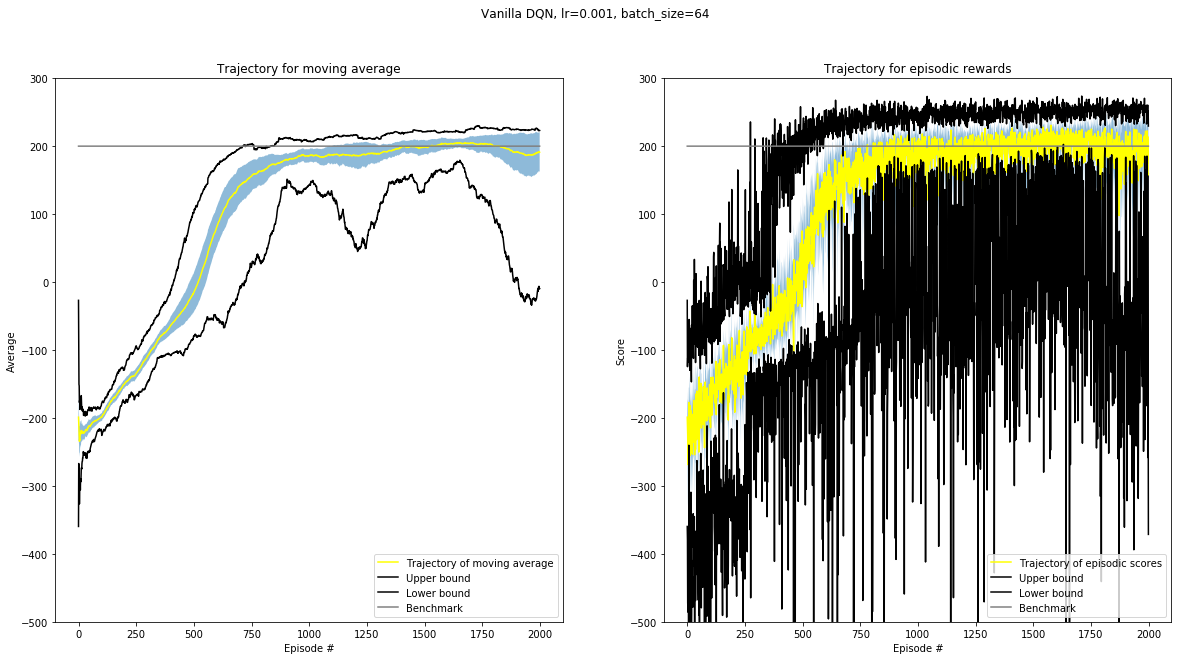

In [20]:
plot_result(scores, means, 'Vanilla DQN, lr=0.001, batch_size=64')

In [16]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    agent.reset(new_lr = 0.0005)
    print('Test No.{}'.format(i+1))
    scores[i,:], _, means[i,:] = agent.train(n_iteration=2000, max_t=1000, learn_schedule=4)

Test No.1
Episode 100	Episodic Score: -238.80	Average Score: -212.22
Episode 200	Episodic Score: -39.82	Average Score: -152.032
Episode 300	Episodic Score: -109.71	Average Score: -117.22
Episode 400	Episodic Score: -33.93	Average Score: -87.9389
Episode 500	Episodic Score: -125.37	Average Score: -42.13
Episode 600	Episodic Score: 164.44	Average Score: 55.4634
Episode 700	Episodic Score: 119.92	Average Score: 148.651
Episode 800	Episodic Score: 206.60	Average Score: 169.72
Episode 900	Episodic Score: 227.35	Average Score: 161.269
Episode 1000	Episodic Score: 186.26	Average Score: 180.16
Episode 1100	Episodic Score: 205.66	Average Score: 171.105
Episode 1200	Episodic Score: 207.10	Average Score: 178.950
Episode 1300	Episodic Score: 190.32	Average Score: 193.803
Episode 1400	Episodic Score: 198.09	Average Score: 190.13
Episode 1500	Episodic Score: 211.26	Average Score: 196.272
Episode 1600	Episodic Score: 215.55	Average Score: 215.46
Episode 1700	Episodic Score: 206.51	Average Score: 216.

Episode 1900	Episodic Score: 211.73	Average Score: 215.02
Episode 2000	Episodic Score: 212.66	Average Score: 214.91
Test No.15
Episode 100	Episodic Score: -118.90	Average Score: -214.49
Episode 200	Episodic Score: -29.19	Average Score: -143.538
Episode 300	Episodic Score: -64.23	Average Score: -113.632
Episode 400	Episodic Score: -64.76	Average Score: -53.0344
Episode 500	Episodic Score: 172.66	Average Score: 17.0318
Episode 600	Episodic Score: 198.06	Average Score: 120.87
Episode 700	Episodic Score: 217.46	Average Score: 160.945
Episode 800	Episodic Score: -68.31	Average Score: 154.87
Episode 900	Episodic Score: 199.20	Average Score: 168.139
Episode 1000	Episodic Score: 234.82	Average Score: 190.77
Episode 1100	Episodic Score: 224.63	Average Score: 207.87
Episode 1200	Episodic Score: 219.24	Average Score: 220.98
Episode 1300	Episodic Score: 220.39	Average Score: 221.40
Episode 1400	Episodic Score: 225.29	Average Score: 224.60
Episode 1500	Episodic Score: 227.75	Average Score: 217.78
E

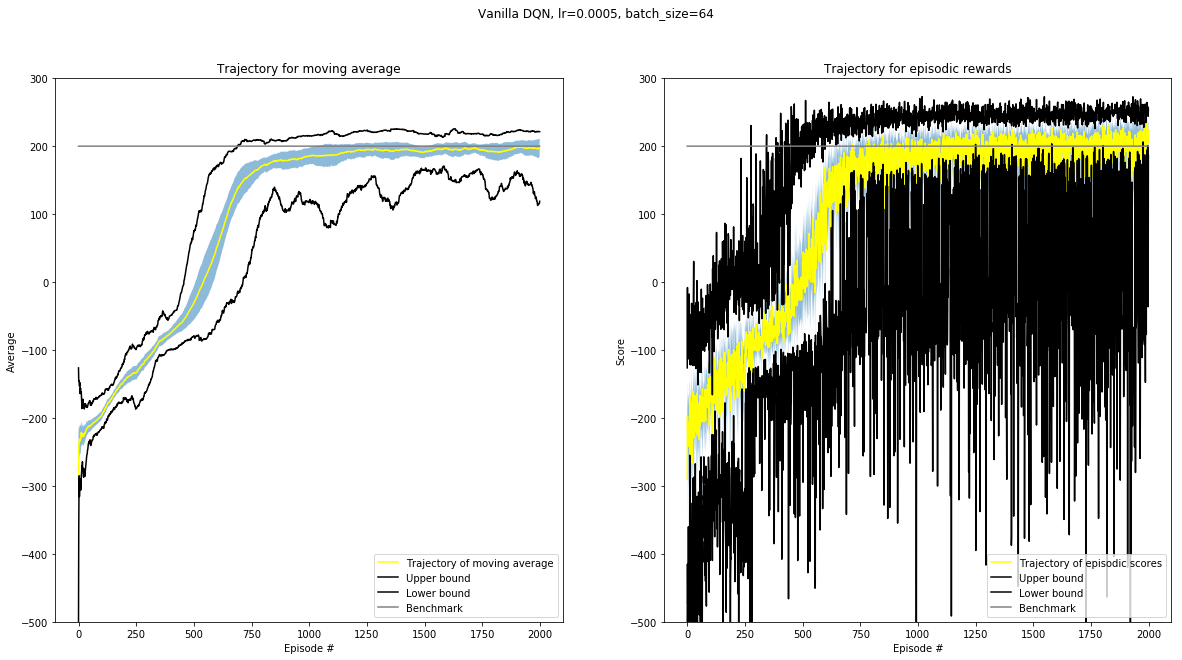

In [18]:
plot_result(scores, means, 'Vanilla DQN, lr=0.0005, batch_size=64')

## SQN

In [10]:
agent = Agent(env=env, learning_rate=0.001, buffer_size=int(1e5), batch_size=64, alpha=0.05, gamma=0.99, tau=0.001,
              action_size=4, double=False, deterministic=False, number=3)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [15]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    agent.reset(new_lr = 0.001, new_alpha=0.005)
    print('Test No.{}'.format(i+1))
    scores[i,:], _, means[i,:] = agent.train(n_iteration=2000, max_t=1000, learn_schedule=4)

Test No.1
Episode 100	Episodic Score: -116.90	Average Score: -289.69
Episode 200	Episodic Score: -274.71	Average Score: -277.25
Episode 300	Episodic Score: -242.68	Average Score: -211.32
Episode 400	Episodic Score: -113.79	Average Score: -170.75
Episode 500	Episodic Score: -418.44	Average Score: -161.97
Episode 600	Episodic Score: -130.05	Average Score: -127.59
Episode 700	Episodic Score: -49.79	Average Score: -85.7748
Episode 800	Episodic Score: -120.12	Average Score: -24.68
Episode 900	Episodic Score: 193.49	Average Score: 119.545
Episode 1000	Episodic Score: 160.15	Average Score: 157.63
Episode 1100	Episodic Score: 140.30	Average Score: 150.604
Episode 1200	Episodic Score: 162.74	Average Score: 119.191
Episode 1300	Episodic Score: 174.72	Average Score: 198.393
Episode 1400	Episodic Score: 174.87	Average Score: 195.406
Episode 1500	Episodic Score: 187.24	Average Score: 189.72
Episode 1600	Episodic Score: 152.65	Average Score: 162.191
Episode 1700	Episodic Score: 187.29	Average Score:

Episode 1700	Episodic Score: 169.48	Average Score: 148.05
Episode 1800	Episodic Score: 213.65	Average Score: 158.02
Episode 1900	Episodic Score: 222.17	Average Score: 168.453
Episode 2000	Episodic Score: 201.25	Average Score: 179.243
Test No.15
Episode 100	Episodic Score: -150.05	Average Score: -242.25
Episode 200	Episodic Score: -169.80	Average Score: -148.36
Episode 300	Episodic Score: -176.34	Average Score: -151.68
Episode 400	Episodic Score: -164.49	Average Score: -132.00
Episode 500	Episodic Score: -58.27	Average Score: -114.028
Episode 600	Episodic Score: -116.90	Average Score: -87.063
Episode 700	Episodic Score: -20.68	Average Score: -71.178
Episode 800	Episodic Score: -82.72	Average Score: -67.321
Episode 900	Episodic Score: -55.90	Average Score: -67.135
Episode 1000	Episodic Score: -28.25	Average Score: -43.44
Episode 1100	Episodic Score: 157.90	Average Score: 128.598
Episode 1200	Episodic Score: 189.40	Average Score: 130.561
Episode 1300	Episodic Score: 208.02	Average Score: 

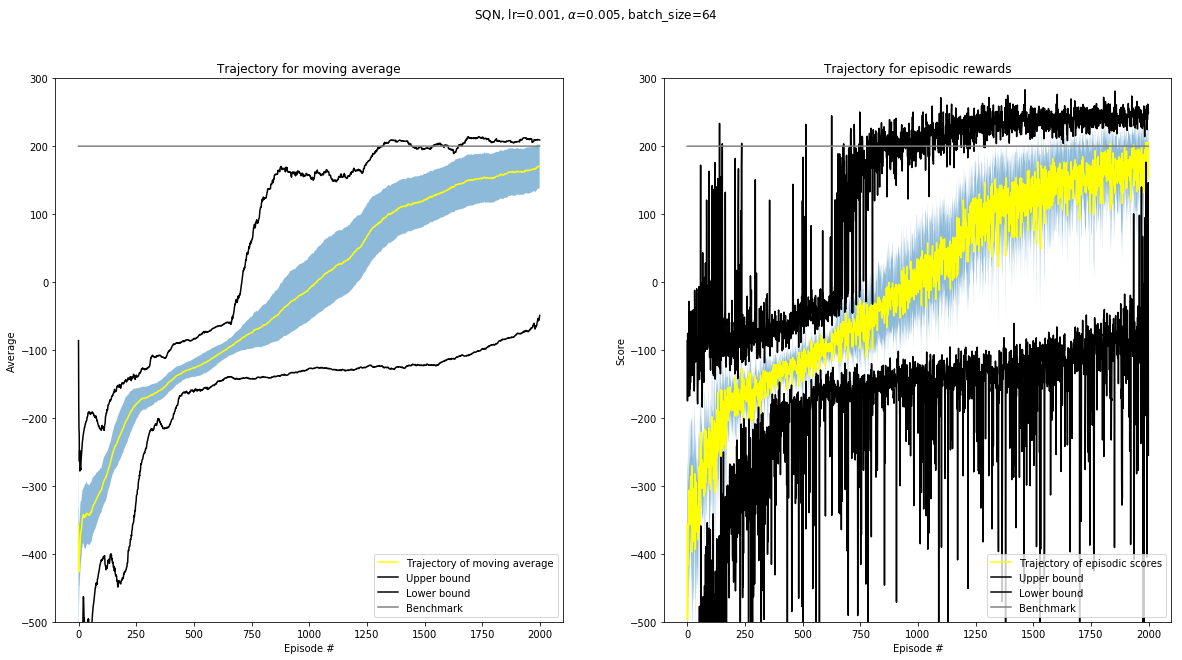

In [16]:
plot_result(scores, means, r'SQN, lr=0.001, $\alpha$=0.005, batch_size=64')

In [9]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    agent.reset(new_lr = 0.001, new_alpha=0.01)
    print('Test No.{}'.format(i+1))
    scores[i,:], _, means[i,:] = agent.train(n_iteration=2000, max_t=1000, learn_schedule=4)

Test No.1
Episode 100	Episodic Score: -181.32	Average Score: -217.20
Episode 200	Episodic Score: -297.17	Average Score: -248.53
Episode 300	Episodic Score: -50.22	Average Score: -203.107
Episode 400	Episodic Score: -78.66	Average Score: -179.080
Episode 500	Episodic Score: -122.06	Average Score: -127.04
Episode 600	Episodic Score: -119.88	Average Score: -94.368
Episode 700	Episodic Score: -70.59	Average Score: -86.744
Episode 800	Episodic Score: -37.75	Average Score: -73.761
Episode 900	Episodic Score: -55.03	Average Score: -60.02
Episode 1000	Episodic Score: -57.45	Average Score: -56.31
Episode 1100	Episodic Score: 39.51	Average Score: 30.93670
Episode 1200	Episodic Score: 111.79	Average Score: 101.37
Episode 1300	Episodic Score: 176.06	Average Score: 183.52
Episode 1400	Episodic Score: 203.41	Average Score: 204.425
Episode 1500	Episodic Score: 244.78	Average Score: 211.10
Episode 1600	Episodic Score: 187.44	Average Score: 179.60
Episode 1700	Episodic Score: 207.43	Average Score: 205.

Episode 1700	Episodic Score: 169.35	Average Score: 158.494
Episode 1800	Episodic Score: 220.12	Average Score: 160.638
Episode 1900	Episodic Score: 194.87	Average Score: 184.19
Episode 2000	Episodic Score: 185.02	Average Score: 189.55
Test No.15
Episode 100	Episodic Score: -34.74	Average Score: -229.30
Episode 200	Episodic Score: -108.63	Average Score: -168.69
Episode 300	Episodic Score: -115.76	Average Score: -156.86
Episode 400	Episodic Score: -138.25	Average Score: -132.43
Episode 500	Episodic Score: -64.96	Average Score: -101.959
Episode 600	Episodic Score: -55.98	Average Score: -66.8704
Episode 700	Episodic Score: -153.97	Average Score: -32.76
Episode 800	Episodic Score: 36.14	Average Score: -5.31214
Episode 900	Episodic Score: 207.38	Average Score: 94.142
Episode 1000	Episodic Score: 182.54	Average Score: 115.66
Episode 1100	Episodic Score: 185.20	Average Score: 155.642
Episode 1200	Episodic Score: 167.20	Average Score: 173.45
Episode 1300	Episodic Score: 226.48	Average Score: 175

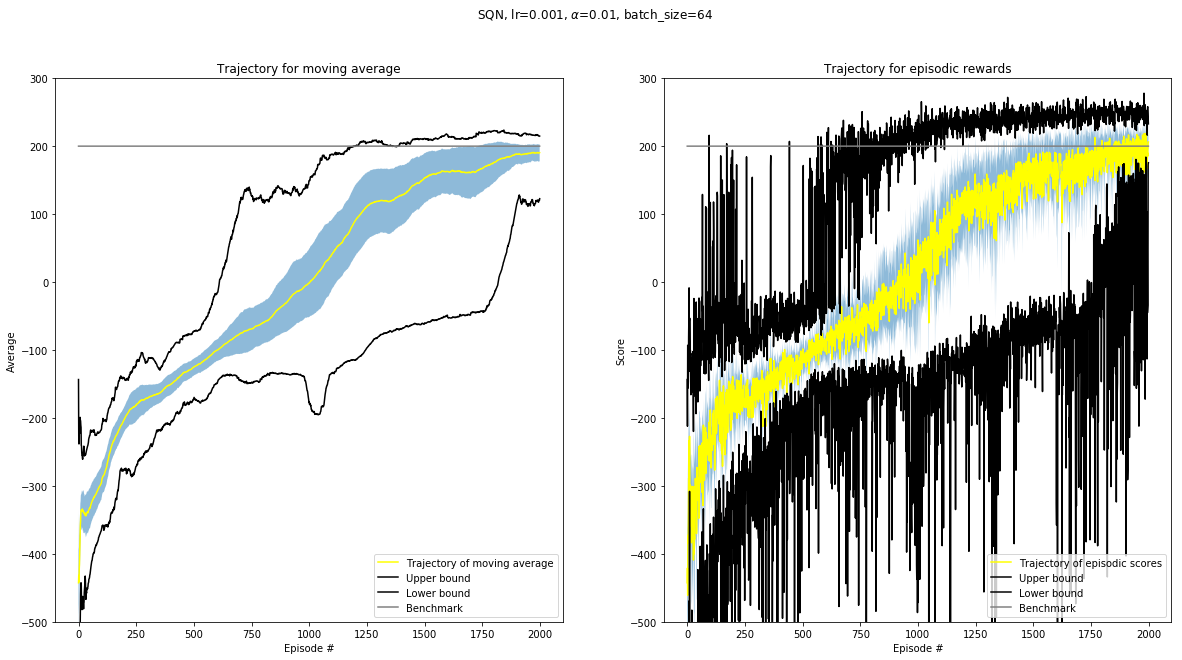

In [10]:
plot_result(scores, means, r'SQN, lr=0.001, $\alpha$=0.01, batch_size=64')

In [11]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    agent.reset(new_lr = 0.001, new_alpha=0.025)
    print('Test No.{}'.format(i+1))
    scores[i,:], _, means[i,:] = agent.train(n_iteration=2000, max_t=1000, learn_schedule=4)

Test No.1
Episode 100	Episodic Score: -296.35	Average Score: -316.96
Episode 200	Episodic Score: -328.37	Average Score: -261.87
Episode 300	Episodic Score: -254.81	Average Score: -271.59
Episode 400	Episodic Score: -284.01	Average Score: -256.39
Episode 500	Episodic Score: -193.32	Average Score: -249.06
Episode 600	Episodic Score: -182.74	Average Score: -212.15
Episode 700	Episodic Score: -169.16	Average Score: -205.56
Episode 800	Episodic Score: -139.39	Average Score: -206.26
Episode 900	Episodic Score: -229.07	Average Score: -206.54
Episode 1000	Episodic Score: -201.37	Average Score: -194.56
Episode 1100	Episodic Score: -185.69	Average Score: -170.07
Episode 1200	Episodic Score: -149.74	Average Score: -163.84
Episode 1300	Episodic Score: -148.97	Average Score: -183.42
Episode 1400	Episodic Score: -112.70	Average Score: -158.62
Episode 1500	Episodic Score: -90.93	Average Score: -113.583
Episode 1600	Episodic Score: -198.27	Average Score: -100.96
Episode 1700	Episodic Score: -69.51	Ave

Episode 1700	Episodic Score: 170.03	Average Score: 199.75
Episode 1800	Episodic Score: 254.75	Average Score: 194.327
Episode 1900	Episodic Score: 168.76	Average Score: 182.35
Episode 2000	Episodic Score: 151.07	Average Score: 159.437
Test No.15
Episode 100	Episodic Score: -494.54	Average Score: -359.41
Episode 200	Episodic Score: -185.29	Average Score: -321.78
Episode 300	Episodic Score: -240.43	Average Score: -293.47
Episode 400	Episodic Score: -194.51	Average Score: -234.54
Episode 500	Episodic Score: -117.34	Average Score: -225.35
Episode 600	Episodic Score: -145.32	Average Score: -136.58
Episode 700	Episodic Score: -130.66	Average Score: -133.45
Episode 800	Episodic Score: -157.58	Average Score: -131.61
Episode 900	Episodic Score: -74.31	Average Score: -117.691
Episode 1000	Episodic Score: -84.41	Average Score: -95.622
Episode 1100	Episodic Score: -113.63	Average Score: -90.76
Episode 1200	Episodic Score: -101.09	Average Score: -76.22
Episode 1300	Episodic Score: -74.35	Average Sco

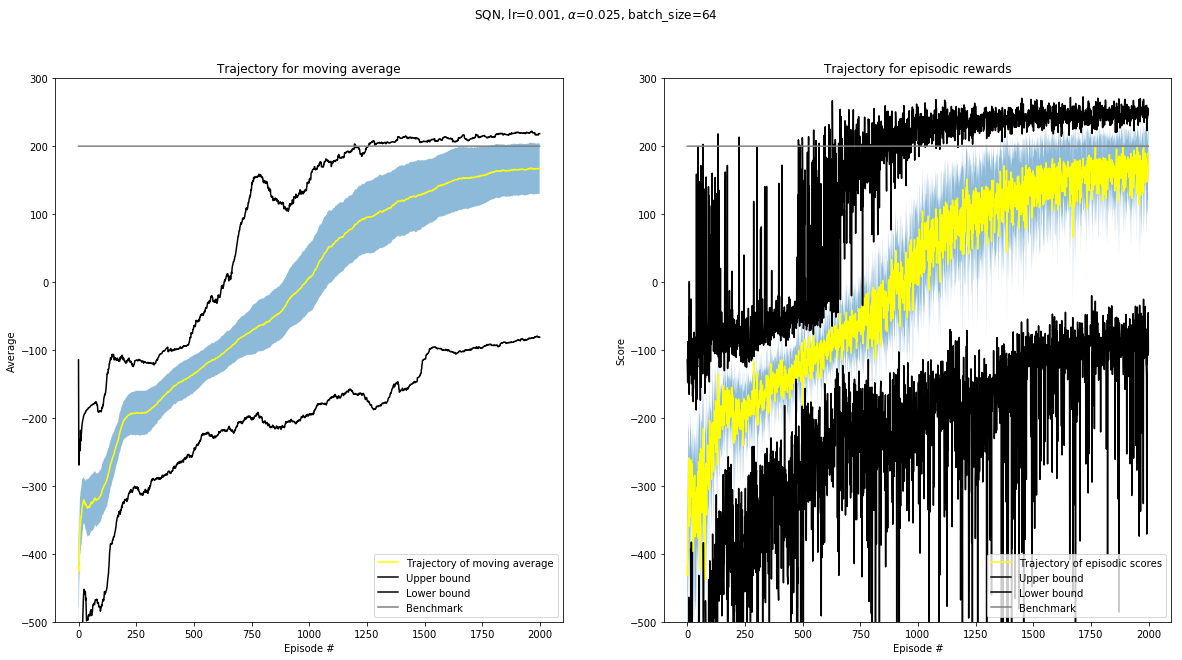

In [12]:
plot_result(scores, means, r'SQN, lr=0.001, $\alpha$=0.025, batch_size=64')

In [13]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    agent.reset(new_lr = 0.001, new_alpha=0.05)
    print('Test No.{}'.format(i+1))
    scores[i,:], _, means[i,:] = agent.train(n_iteration=2000, max_t=1000, learn_schedule=4)

Test No.1
Episode 100	Episodic Score: -21.08	Average Score: -197.81
Episode 200	Episodic Score: -239.72	Average Score: -232.15
Episode 300	Episodic Score: -344.21	Average Score: -296.13
Episode 400	Episodic Score: -209.13	Average Score: -224.55
Episode 500	Episodic Score: -180.26	Average Score: -180.26
Episode 600	Episodic Score: -112.13	Average Score: -126.06
Episode 700	Episodic Score: -117.07	Average Score: -130.14
Episode 800	Episodic Score: -134.23	Average Score: -122.02
Episode 900	Episodic Score: -102.22	Average Score: -118.55
Episode 1000	Episodic Score: -104.65	Average Score: -105.89
Episode 1100	Episodic Score: -118.97	Average Score: -104.97
Episode 1200	Episodic Score: -89.70	Average Score: -92.5984
Episode 1300	Episodic Score: -105.12	Average Score: -83.65
Episode 1400	Episodic Score: -37.62	Average Score: -75.073
Episode 1500	Episodic Score: -44.69	Average Score: -64.979
Episode 1600	Episodic Score: -35.17	Average Score: -61.054
Episode 1700	Episodic Score: -51.25	Average 

Episode 1600	Episodic Score: 190.30	Average Score: 188.97
Episode 1700	Episodic Score: 194.20	Average Score: 189.60
Episode 1800	Episodic Score: 166.49	Average Score: 166.608
Episode 1900	Episodic Score: -104.26	Average Score: 142.84
Episode 2000	Episodic Score: 200.77	Average Score: 165.265
Test No.15
Episode 100	Episodic Score: -300.07	Average Score: -327.14
Episode 200	Episodic Score: -266.17	Average Score: -277.95
Episode 300	Episodic Score: -204.64	Average Score: -223.97
Episode 400	Episodic Score: -121.62	Average Score: -139.17
Episode 500	Episodic Score: -112.54	Average Score: -110.21
Episode 600	Episodic Score: -101.77	Average Score: -105.27
Episode 700	Episodic Score: -135.56	Average Score: -112.69
Episode 800	Episodic Score: -93.12	Average Score: -104.061
Episode 900	Episodic Score: -119.98	Average Score: -90.635
Episode 1000	Episodic Score: -75.05	Average Score: -80.81
Episode 1100	Episodic Score: -121.76	Average Score: -94.46
Episode 1200	Episodic Score: 102.68	Average Scor

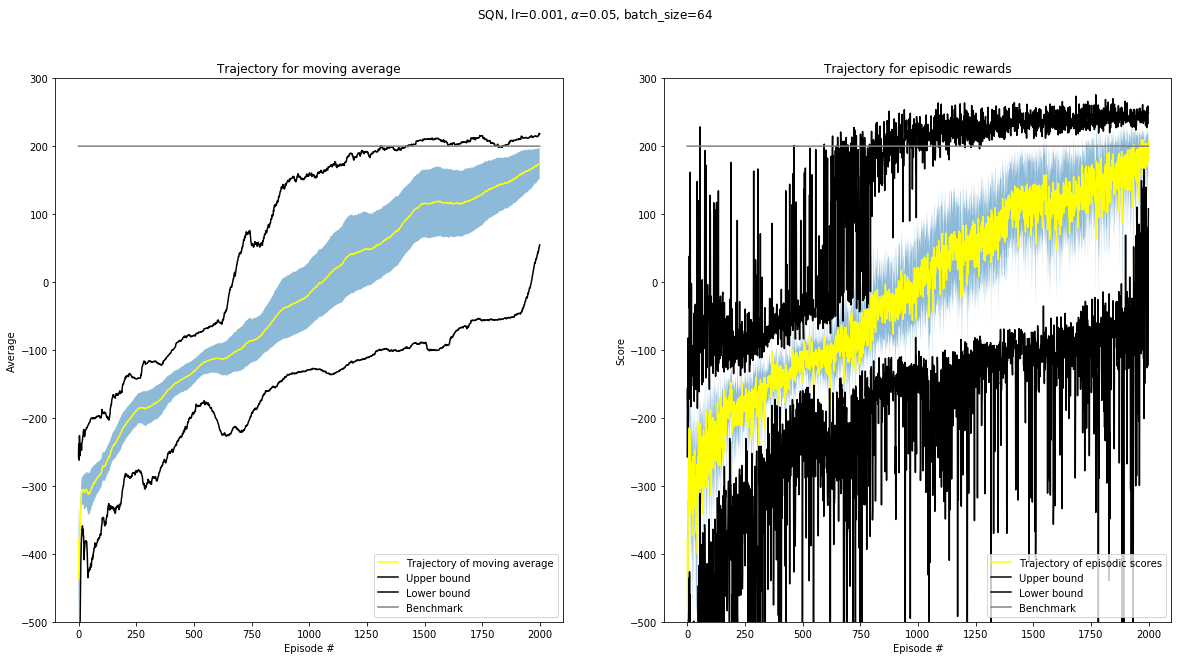

In [14]:
plot_result(scores, means, r'SQN, lr=0.001, $\alpha$=0.05, batch_size=64')

In [17]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    agent.reset(new_lr = 0.001, new_alpha=0.1)
    print('Test No.{}'.format(i+1))
    scores[i,:], _, means[i,:] = agent.train(n_iteration=2000, max_t=1000, learn_schedule=4)

Test No.1
Episode 100	Episodic Score: -270.86	Average Score: -177.73
Episode 200	Episodic Score: -119.10	Average Score: -146.46
Episode 300	Episodic Score: -139.80	Average Score: -139.77
Episode 400	Episodic Score: -151.00	Average Score: -124.79
Episode 500	Episodic Score: -110.97	Average Score: -96.740
Episode 600	Episodic Score: 113.14	Average Score: -35.2169
Episode 700	Episodic Score: 150.16	Average Score: 64.5054
Episode 800	Episodic Score: 186.21	Average Score: 164.392
Episode 900	Episodic Score: 197.10	Average Score: 129.746
Episode 1000	Episodic Score: -96.09	Average Score: -139.48
Episode 1100	Episodic Score: 174.12	Average Score: 8.813590
Episode 1200	Episodic Score: 132.27	Average Score: 136.712
Episode 1300	Episodic Score: 207.59	Average Score: 193.60
Episode 1400	Episodic Score: 187.82	Average Score: 210.46
Episode 1500	Episodic Score: 227.98	Average Score: 208.74
Episode 1600	Episodic Score: 227.77	Average Score: 188.35
Episode 1700	Episodic Score: 235.47	Average Score: 1

Episode 1800	Episodic Score: 172.90	Average Score: 176.005
Episode 1900	Episodic Score: 218.86	Average Score: 188.023
Episode 2000	Episodic Score: -92.67	Average Score: 190.552
Test No.15
Episode 100	Episodic Score: -365.62	Average Score: -331.87
Episode 200	Episodic Score: -147.21	Average Score: -147.83
Episode 300	Episodic Score: -135.91	Average Score: -131.17
Episode 400	Episodic Score: -85.44	Average Score: -104.323
Episode 500	Episodic Score: -75.69	Average Score: -96.7440
Episode 600	Episodic Score: -62.01	Average Score: -76.117
Episode 700	Episodic Score: -48.21	Average Score: -58.454
Episode 800	Episodic Score: -26.37	Average Score: -43.60
Episode 900	Episodic Score: 95.87	Average Score: 36.1002
Episode 1000	Episodic Score: 47.23	Average Score: 83.302
Episode 1100	Episodic Score: -18.34	Average Score: 88.954
Episode 1200	Episodic Score: 215.89	Average Score: 189.519
Episode 1300	Episodic Score: 198.88	Average Score: 211.66
Episode 1400	Episodic Score: 228.38	Average Score: 210.

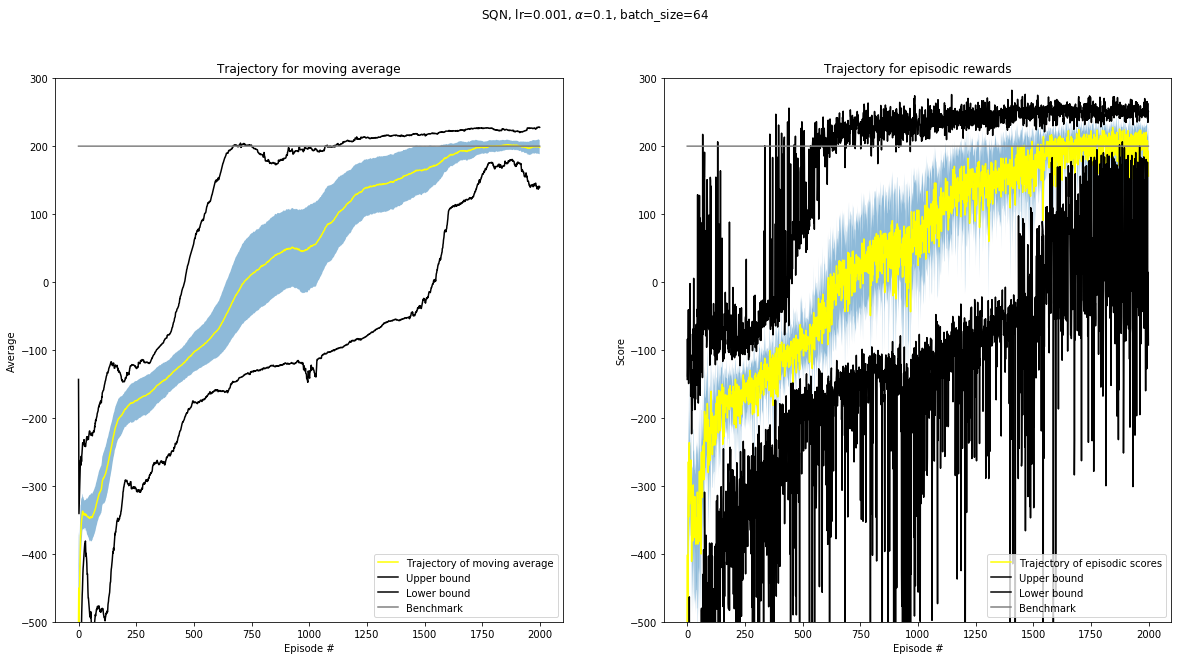

In [18]:
plot_result(scores, means, r'SQN, lr=0.001, $\alpha$=0.1, batch_size=64')

In [19]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    agent.reset(new_lr = 0.001, new_alpha=0.15)
    print('Test No.{}'.format(i+1))
    scores[i,:], _, means[i,:] = agent.train(n_iteration=2000, max_t=1000, learn_schedule=4)

Test No.1
Episode 100	Episodic Score: -180.24	Average Score: -303.69
Episode 200	Episodic Score: -135.52	Average Score: -183.26
Episode 300	Episodic Score: -128.43	Average Score: -154.35
Episode 400	Episodic Score: -86.70	Average Score: -113.278
Episode 500	Episodic Score: -38.98	Average Score: -81.9980
Episode 600	Episodic Score: 169.51	Average Score: 78.4289
Episode 700	Episodic Score: 178.28	Average Score: 140.21
Episode 800	Episodic Score: 157.93	Average Score: 171.125
Episode 900	Episodic Score: 210.36	Average Score: 182.643
Episode 1000	Episodic Score: 206.84	Average Score: 191.11
Episode 1100	Episodic Score: 204.78	Average Score: 192.44
Episode 1200	Episodic Score: 245.72	Average Score: 183.01
Episode 1300	Episodic Score: 260.54	Average Score: 166.444
Episode 1400	Episodic Score: 236.72	Average Score: 184.41
Episode 1500	Episodic Score: 241.10	Average Score: 191.521
Episode 1600	Episodic Score: 214.25	Average Score: 196.298
Episode 1700	Episodic Score: 197.15	Average Score: 187.

Episode 1800	Episodic Score: 194.53	Average Score: 211.80
Episode 1900	Episodic Score: 266.18	Average Score: 199.609
Episode 2000	Episodic Score: 212.90	Average Score: 206.46
Test No.15
Episode 100	Episodic Score: -87.75	Average Score: -196.43
Episode 200	Episodic Score: -187.19	Average Score: -174.40
Episode 300	Episodic Score: -225.33	Average Score: -166.02
Episode 400	Episodic Score: -95.90	Average Score: -148.132
Episode 500	Episodic Score: -88.03	Average Score: -104.170
Episode 600	Episodic Score: 124.19	Average Score: -28.370
Episode 700	Episodic Score: 175.00	Average Score: 151.129
Episode 800	Episodic Score: 208.29	Average Score: 155.96
Episode 900	Episodic Score: 215.17	Average Score: 200.69
Episode 1000	Episodic Score: 170.65	Average Score: 196.14
Episode 1100	Episodic Score: 199.03	Average Score: 201.20
Episode 1200	Episodic Score: 228.60	Average Score: 170.454
Episode 1300	Episodic Score: 158.20	Average Score: 151.328
Episode 1400	Episodic Score: 209.21	Average Score: 151.0

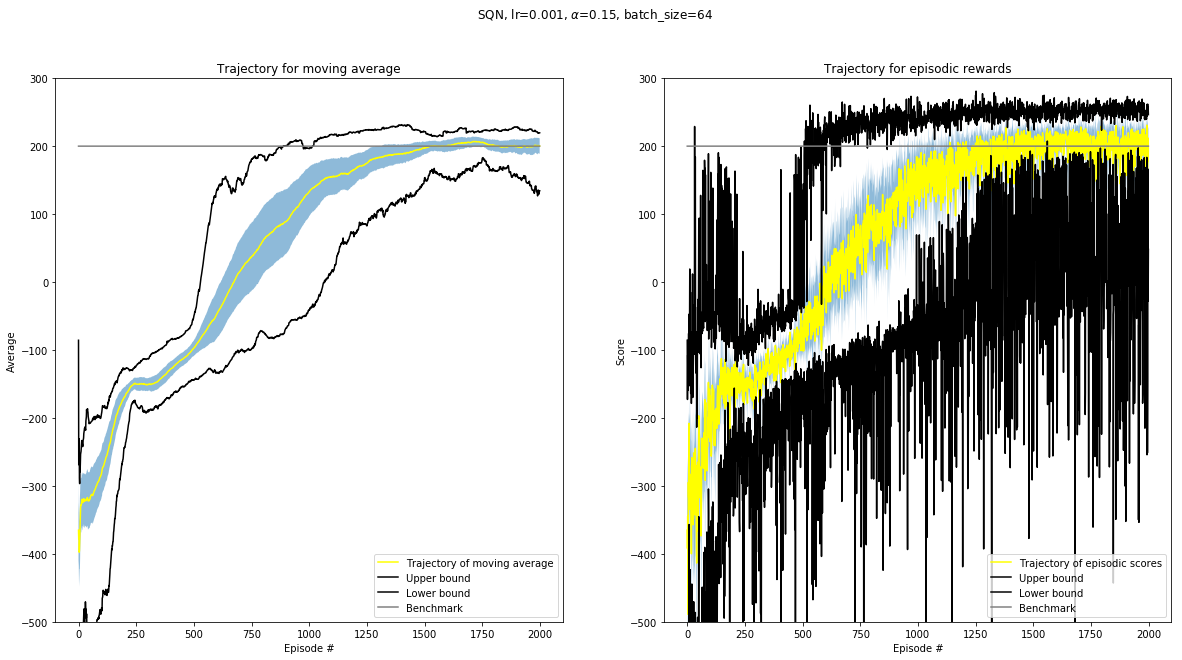

In [20]:
plot_result(scores, means, r'SQN, lr=0.001, $\alpha$=0.15, batch_size=64')

In [13]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    agent.reset(new_lr = 0.001, new_alpha=0.2)
    print('Test No.{}'.format(i+1))
    scores[i,:], _, means[i,:] = agent.train(n_iteration=2000, max_t=1000, learn_schedule=4)

Test No.1
Episode 100	Episodic Score: -117.22	Average Score: -315.51
Episode 200	Episodic Score: -161.28	Average Score: -184.44
Episode 300	Episodic Score: -128.79	Average Score: -133.73
Episode 400	Episodic Score: -37.28	Average Score: -86.1246
Episode 500	Episodic Score: -41.15	Average Score: -60.557
Episode 600	Episodic Score: 13.19	Average Score: -52.3939
Episode 700	Episodic Score: 112.79	Average Score: -35.084
Episode 800	Episodic Score: -44.50	Average Score: 61.0895
Episode 900	Episodic Score: 199.32	Average Score: 40.814
Episode 1000	Episodic Score: 44.34	Average Score: 76.866
Episode 1100	Episodic Score: -82.52	Average Score: -8.310
Episode 1200	Episodic Score: -19.49	Average Score: 45.9770
Episode 1300	Episodic Score: 78.92	Average Score: 168.978
Episode 1400	Episodic Score: 182.92	Average Score: 177.46
Episode 1500	Episodic Score: 205.93	Average Score: 178.358
Episode 1600	Episodic Score: 214.10	Average Score: 203.56
Episode 1700	Episodic Score: 182.74	Average Score: 189.657

Episode 1900	Episodic Score: 242.14	Average Score: 173.007
Episode 2000	Episodic Score: 204.76	Average Score: 205.84
Test No.15
Episode 100	Episodic Score: -350.54	Average Score: -342.25
Episode 200	Episodic Score: -298.16	Average Score: -287.961
Episode 300	Episodic Score: -122.69	Average Score: -215.89
Episode 400	Episodic Score: -192.36	Average Score: -137.80
Episode 500	Episodic Score: -66.26	Average Score: -114.548
Episode 600	Episodic Score: -48.86	Average Score: -99.0078
Episode 700	Episodic Score: -78.59	Average Score: -102.719
Episode 800	Episodic Score: -107.71	Average Score: -46.59
Episode 900	Episodic Score: 185.77	Average Score: 24.5330
Episode 1000	Episodic Score: 175.02	Average Score: 146.35
Episode 1100	Episodic Score: 218.26	Average Score: 199.46
Episode 1200	Episodic Score: 210.81	Average Score: 189.003
Episode 1300	Episodic Score: 217.08	Average Score: 185.27
Episode 1400	Episodic Score: 138.94	Average Score: 150.738
Episode 1500	Episodic Score: 214.75	Average Score:

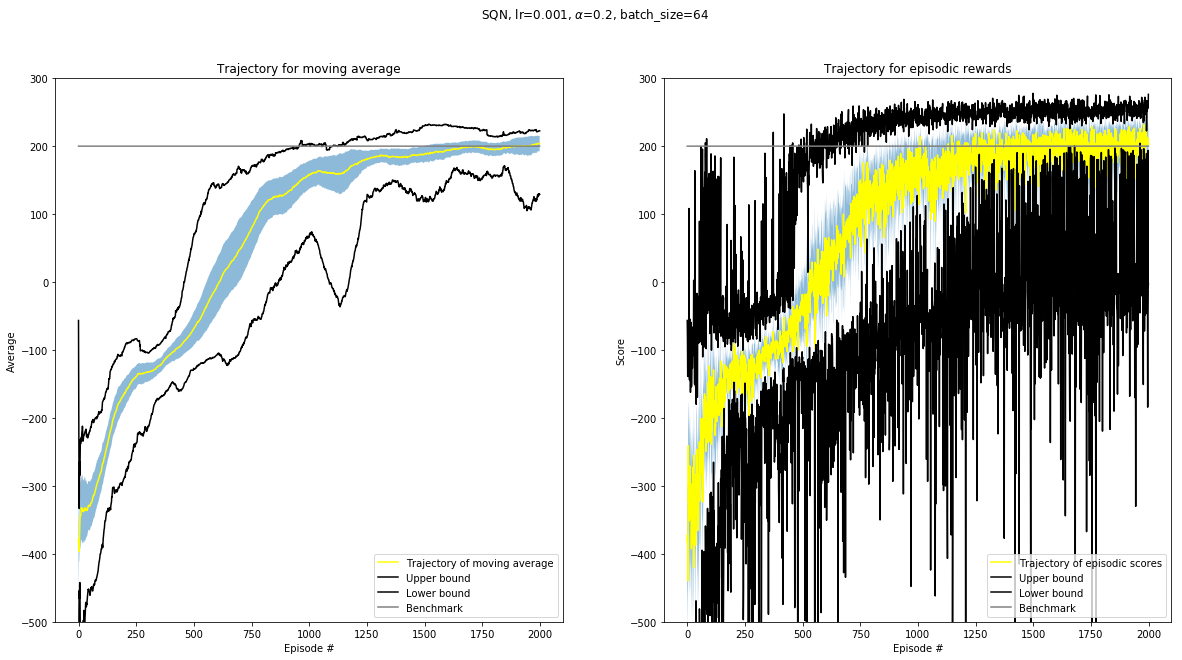

In [14]:
plot_result(scores, means, r'SQN, lr=0.001, $\alpha$=0.2, batch_size=64')

In [11]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    agent.reset(new_lr = 0.001, new_alpha=0.25)
    print('Test No.{}'.format(i+1))
    scores[i,:], _, means[i,:] = agent.train(n_iteration=2000, max_t=1000, learn_schedule=4)

Test No.1
Episode 100	Episodic Score: -221.85	Average Score: -348.76
Episode 200	Episodic Score: -68.20	Average Score: -207.908
Episode 300	Episodic Score: -327.03	Average Score: -161.20
Episode 400	Episodic Score: -106.44	Average Score: -130.68
Episode 500	Episodic Score: -100.94	Average Score: -95.479
Episode 600	Episodic Score: 92.46	Average Score: -67.4826
Episode 700	Episodic Score: 94.85	Average Score: 34.05361
Episode 800	Episodic Score: 92.37	Average Score: 84.027
Episode 900	Episodic Score: 82.82	Average Score: 101.621
Episode 1000	Episodic Score: 82.62	Average Score: 93.4983
Episode 1100	Episodic Score: 86.68	Average Score: 95.1494
Episode 1200	Episodic Score: 80.02	Average Score: 92.316
Episode 1300	Episodic Score: 64.61	Average Score: 92.7325
Episode 1400	Episodic Score: 57.17	Average Score: 101.729
Episode 1500	Episodic Score: 54.66	Average Score: 102.468
Episode 1600	Episodic Score: 67.03	Average Score: 82.1083
Episode 1700	Episodic Score: 195.20	Average Score: 186.208
Ep

Episode 1900	Episodic Score: 238.08	Average Score: 213.32
Episode 2000	Episodic Score: 223.70	Average Score: 220.74
Test No.15
Episode 100	Episodic Score: -360.07	Average Score: -257.84
Episode 200	Episodic Score: -121.23	Average Score: -223.04
Episode 300	Episodic Score: -125.81	Average Score: -112.61
Episode 400	Episodic Score: -65.47	Average Score: -124.651
Episode 500	Episodic Score: -57.93	Average Score: -69.5653
Episode 600	Episodic Score: -42.75	Average Score: -57.607
Episode 700	Episodic Score: -81.47	Average Score: 4.63350
Episode 800	Episodic Score: 102.78	Average Score: 88.977
Episode 900	Episodic Score: 188.55	Average Score: 188.81
Episode 1000	Episodic Score: 215.57	Average Score: 192.18
Episode 1100	Episodic Score: 185.86	Average Score: 187.61
Episode 1200	Episodic Score: 174.38	Average Score: 191.15
Episode 1300	Episodic Score: 207.27	Average Score: 198.30
Episode 1400	Episodic Score: 205.94	Average Score: 190.29
Episode 1500	Episodic Score: 201.76	Average Score: 212.60


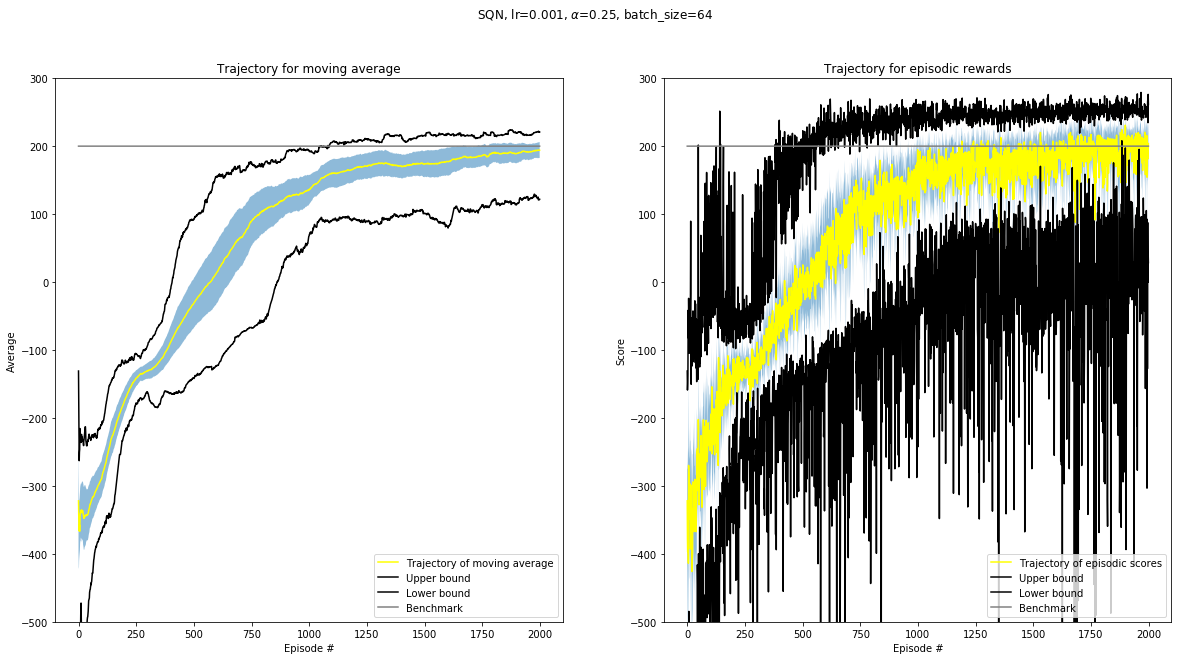

In [12]:
plot_result(scores, means, r'SQN, lr=0.001, $\alpha$=0.25, batch_size=64')

## A smaller learning rate

Here we only choose some $\alpha$ which seems to be promising.

In [15]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    agent.reset(new_lr = 0.0005, new_alpha=0.1)
    print('Test No.{}'.format(i+1))
    scores[i,:], _, means[i,:] = agent.train(n_iteration=2000, max_t=1000, learn_schedule=4)

Test No.1
Episode 100	Episodic Score: -75.19	Average Score: -176.28
Episode 200	Episodic Score: -146.42	Average Score: -95.623
Episode 300	Episodic Score: -137.72	Average Score: -168.44
Episode 400	Episodic Score: -114.71	Average Score: -122.30
Episode 500	Episodic Score: -111.77	Average Score: -109.92
Episode 600	Episodic Score: -76.60	Average Score: -106.738
Episode 700	Episodic Score: -59.61	Average Score: -74.4858
Episode 800	Episodic Score: -38.86	Average Score: 77.4161
Episode 900	Episodic Score: 164.75	Average Score: 124.918
Episode 1000	Episodic Score: 90.00	Average Score: 138.334
Episode 1100	Episodic Score: 221.02	Average Score: 131.222
Episode 1200	Episodic Score: 203.33	Average Score: 172.01
Episode 1300	Episodic Score: 179.36	Average Score: 185.118
Episode 1400	Episodic Score: 164.62	Average Score: 197.29
Episode 1500	Episodic Score: 239.00	Average Score: 190.63
Episode 1600	Episodic Score: 216.81	Average Score: 198.73
Episode 1700	Episodic Score: 240.52	Average Score: 196

Episode 1700	Episodic Score: 213.42	Average Score: 183.896
Episode 1800	Episodic Score: 183.03	Average Score: 153.951
Episode 1900	Episodic Score: -69.32	Average Score: 184.34
Episode 2000	Episodic Score: 212.15	Average Score: 180.80
Test No.15
Episode 100	Episodic Score: -393.36	Average Score: -332.16
Episode 200	Episodic Score: -111.47	Average Score: -186.18
Episode 300	Episodic Score: -172.82	Average Score: -154.75
Episode 400	Episodic Score: -87.66	Average Score: -115.391
Episode 500	Episodic Score: -106.42	Average Score: -81.351
Episode 600	Episodic Score: -127.06	Average Score: -57.79
Episode 700	Episodic Score: 161.56	Average Score: 14.4800
Episode 800	Episodic Score: 196.14	Average Score: 32.639
Episode 900	Episodic Score: 193.44	Average Score: 76.133
Episode 1000	Episodic Score: 129.56	Average Score: 65.94
Episode 1100	Episodic Score: 103.70	Average Score: 131.22
Episode 1200	Episodic Score: 185.40	Average Score: 132.877
Episode 1300	Episodic Score: 206.61	Average Score: 148.8

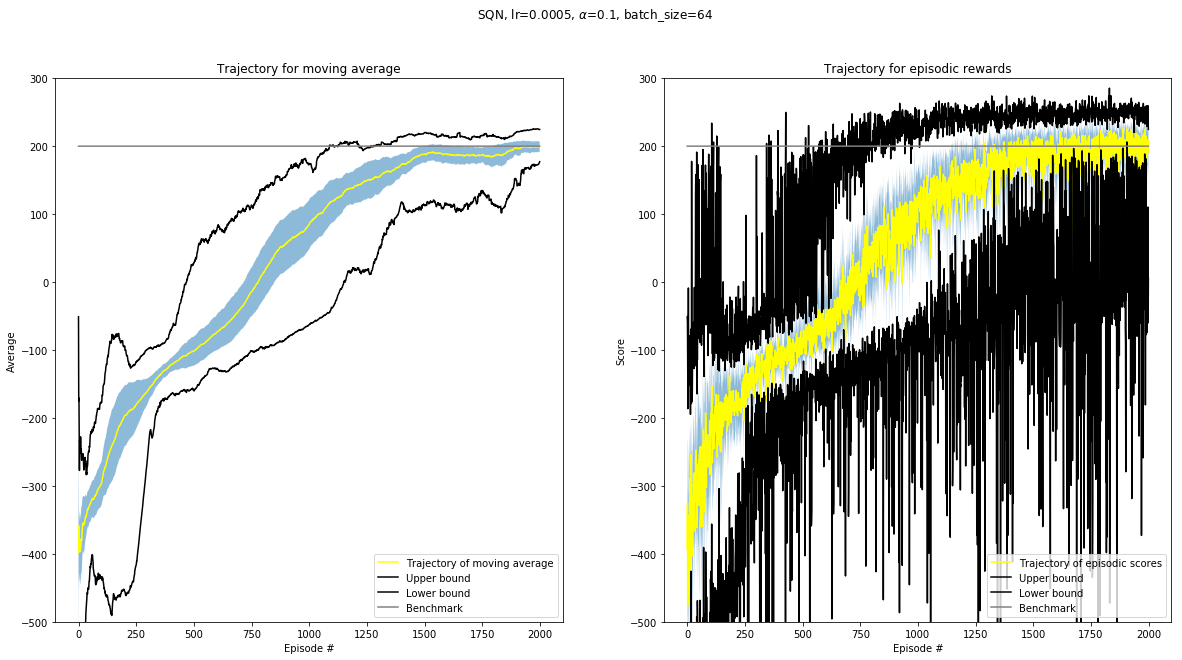

In [16]:
plot_result(scores, means, r'SQN, lr=0.0005, $\alpha$=0.1, batch_size=64')

In [17]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    agent.reset(new_lr = 0.0005, new_alpha=0.15)
    print('Test No.{}'.format(i+1))
    scores[i,:], _, means[i,:] = agent.train(n_iteration=2000, max_t=1000, learn_schedule=4)

Test No.1
Episode 100	Episodic Score: 164.72	Average Score: -280.19
Episode 200	Episodic Score: -140.73	Average Score: -120.45
Episode 300	Episodic Score: -119.07	Average Score: -138.58
Episode 400	Episodic Score: -98.13	Average Score: -117.814
Episode 500	Episodic Score: -85.29	Average Score: -144.607
Episode 600	Episodic Score: -155.17	Average Score: -84.944
Episode 700	Episodic Score: -181.24	Average Score: -76.70
Episode 800	Episodic Score: -55.15	Average Score: -20.543
Episode 900	Episodic Score: 235.49	Average Score: 76.7039
Episode 1000	Episodic Score: 196.65	Average Score: 180.49
Episode 1100	Episodic Score: 242.10	Average Score: 203.53
Episode 1200	Episodic Score: 221.48	Average Score: 181.141
Episode 1300	Episodic Score: 211.65	Average Score: 180.278
Episode 1400	Episodic Score: 224.91	Average Score: 175.219
Episode 1500	Episodic Score: -14.38	Average Score: 179.59
Episode 1600	Episodic Score: 219.81	Average Score: 209.64
Episode 1700	Episodic Score: 193.65	Average Score: 213

Episode 1800	Episodic Score: 223.33	Average Score: 206.59
Episode 1900	Episodic Score: 201.55	Average Score: 200.80
Episode 2000	Episodic Score: 233.17	Average Score: 201.34
Test No.15
Episode 100	Episodic Score: -79.57	Average Score: -336.72
Episode 200	Episodic Score: -89.46	Average Score: -129.984
Episode 300	Episodic Score: -85.42	Average Score: -114.604
Episode 400	Episodic Score: -39.25	Average Score: -87.1052
Episode 500	Episodic Score: -85.92	Average Score: -46.882
Episode 600	Episodic Score: -84.49	Average Score: 41.5901
Episode 700	Episodic Score: 105.20	Average Score: 108.17
Episode 800	Episodic Score: 175.73	Average Score: 131.021
Episode 900	Episodic Score: 189.24	Average Score: 145.036
Episode 1000	Episodic Score: 225.78	Average Score: 166.45
Episode 1100	Episodic Score: 227.94	Average Score: 186.382
Episode 1200	Episodic Score: 223.98	Average Score: 180.40
Episode 1300	Episodic Score: 227.96	Average Score: 197.89
Episode 1400	Episodic Score: 177.57	Average Score: 198.09


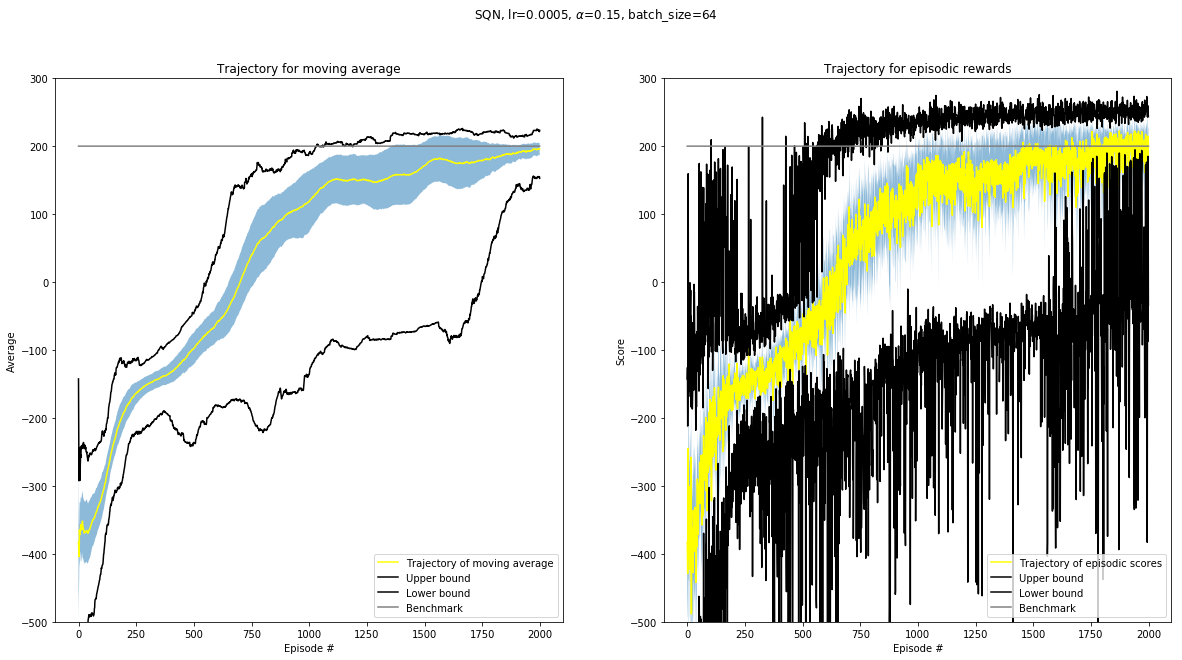

In [18]:
plot_result(scores, means, r'SQN, lr=0.0005, $\alpha$=0.15, batch_size=64')

In [19]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    agent.reset(new_lr = 0.0005, new_alpha=0.2)
    print('Test No.{}'.format(i+1))
    scores[i,:], _, means[i,:] = agent.train(n_iteration=2000, max_t=1000, learn_schedule=4)

Test No.1
Episode 100	Episodic Score: -327.94	Average Score: -183.09
Episode 200	Episodic Score: -196.77	Average Score: -153.22
Episode 300	Episodic Score: -151.99	Average Score: -142.39
Episode 400	Episodic Score: -89.40	Average Score: -83.3473
Episode 500	Episodic Score: -144.89	Average Score: -59.82
Episode 600	Episodic Score: -73.63	Average Score: -9.5015
Episode 700	Episodic Score: 190.82	Average Score: 35.8958
Episode 800	Episodic Score: 214.98	Average Score: 84.666
Episode 900	Episodic Score: 189.40	Average Score: 161.852
Episode 1000	Episodic Score: 112.08	Average Score: 128.20
Episode 1100	Episodic Score: 34.90	Average Score: 116.085
Episode 1200	Episodic Score: 86.13	Average Score: 63.0098
Episode 1300	Episodic Score: 107.60	Average Score: 123.94
Episode 1400	Episodic Score: 100.76	Average Score: 124.151
Episode 1500	Episodic Score: 199.44	Average Score: 163.264
Episode 1600	Episodic Score: 257.66	Average Score: 196.422
Episode 1700	Episodic Score: 125.40	Average Score: 208.6

Episode 1900	Episodic Score: 214.40	Average Score: 213.239
Episode 2000	Episodic Score: 210.43	Average Score: 209.540
Test No.15
Episode 100	Episodic Score: -116.89	Average Score: -217.00
Episode 200	Episodic Score: -236.05	Average Score: -141.78
Episode 300	Episodic Score: -115.25	Average Score: -164.41
Episode 400	Episodic Score: -44.96	Average Score: -85.6997
Episode 500	Episodic Score: -46.34	Average Score: -55.939
Episode 600	Episodic Score: -83.97	Average Score: -19.950
Episode 700	Episodic Score: 80.76	Average Score: 9.028744
Episode 800	Episodic Score: 224.03	Average Score: 68.973
Episode 900	Episodic Score: 95.47	Average Score: 105.632
Episode 1000	Episodic Score: 100.06	Average Score: 125.46
Episode 1100	Episodic Score: 111.14	Average Score: 123.26
Episode 1200	Episodic Score: 252.09	Average Score: 152.03
Episode 1300	Episodic Score: 221.61	Average Score: 178.70
Episode 1400	Episodic Score: 153.24	Average Score: 187.89
Episode 1500	Episodic Score: 189.86	Average Score: 188.18

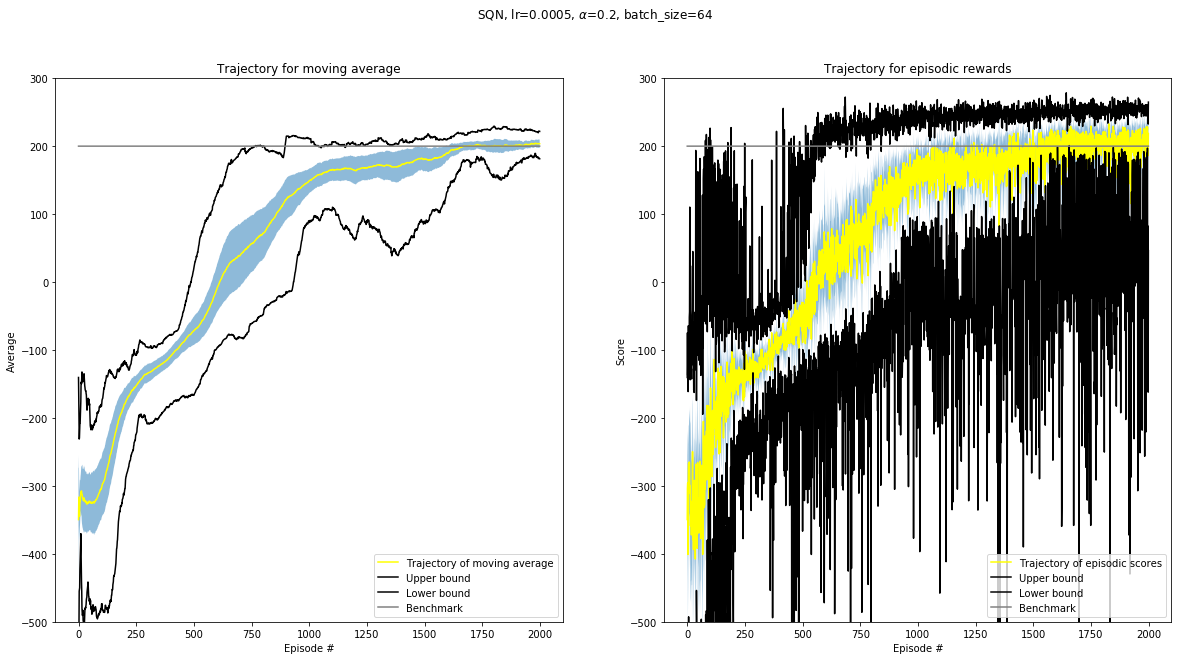

In [20]:
plot_result(scores, means, r'SQN, lr=0.0005, $\alpha$=0.2, batch_size=64')

# Some Conclusion

    1. First of all we should realize that Reinforcement Learning is very sensitive to parameter tuning
    2. One algorithm might not be better over another one. The performance also depends on the task
    3. For SQN, larger $\alpha$ does not necessarily harm the reward since it encourages early exploration
    4. A smaller learning rate usually provides a stable learning curve but also learns slower.
